# 70-text-training
> Training models

In this notebook, I fine-tuned the model "bert-base-cased" using tokenizer encodings. 80% of original data is used as training data, and 10% of the original data is used as test data. This fine-tuend model shows 93% accuracy on test dataset.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from datasets import load_dataset, load_metric, Dataset

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report
import torch

import os

# Load data

In this section, we're going to use directly load the full CSV of all of the data and use it directly.

In [10]:
# I imported "final_add_split.csv" file from my own ACCRE. You should change the path of the file.
base_prefix = os.path.expanduser('/data/p_dsi/wise/data/cleaned_data/')
file_dir = base_prefix + 'final_csv_wsplits.csv'
data = pd.read_csv(file_dir)

In [11]:
data.head()

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id,split
0,135-2,~ise/data/cleaned_data/cleaned_transcripts/135...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,if we do 100 and we use the power of ten we mu...,00:01:05.04,00:02:02.05,OTR,198,0
1,252-1,~ise/data/cleaned_data/cleaned_transcripts/252...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,raise your fingers.,00:06:14.05,00:07:18.00,OTR,198,0
2,116-3,~ise/data/cleaned_data/cleaned_transcripts/116...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,well you know what I will take this.,00:02:03.24,00:04:05.01,NEU,198,0
3,251-1,~ise/data/cleaned_data/cleaned_transcripts/251...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,the body.,00:08:09.01,00:10:02.02,NEU,198,0
4,252-2,~ise/data/cleaned_data/cleaned_transcripts/252...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,I'm gonna actually underline these two sentenc...,00:06:09.00,00:07:35.27,NEU,198,0


To make a computer understand each label, labels such as "PRS" and "REP" should be converted to a numerical value. Therefore we are going to make a new column called "label_digit" and we are going to assign a value like this:

- PRS : 0
- REP : 1
- NEU : 2
- OTR : 3

In [12]:
# Add column 'label_digit' to convert classes' type into numbers.
conditions = [
    (data['label'] == "PRS"),
    (data['label'] == 'REP'),
    (data['label'] == 'NEU'),
    (data['label'] == "OTR")
    ]

values = [0, 1, 2, 3]

data['label_digit'] = np.select(conditions, values)

In [13]:
data.head()

,id,transcript_filepath,wave_filename,speech,start_timestamp,end_timestamp,label,transcriber_id,split,label_digit
0,135-2,~ise/data/cleaned_data/cleaned_transcripts/135...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,if we do 100 and we use the power of ten we mu...,00:01:05.04,00:02:02.05,OTR,198,0,3
1,252-1,~ise/data/cleaned_data/cleaned_transcripts/252...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,raise your fingers.,00:06:14.05,00:07:18.00,OTR,198,0,3
2,116-3,~ise/data/cleaned_data/cleaned_transcripts/116...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,well you know what I will take this.,00:02:03.24,00:04:05.01,NEU,198,0,2
3,251-1,~ise/data/cleaned_data/cleaned_transcripts/251...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,the body.,00:08:09.01,00:10:02.02,NEU,198,0,2
4,252-2,~ise/data/cleaned_data/cleaned_transcripts/252...,/data/p_dsi/wise/data/Audio Files & Tanscripts...,I'm gonna actually underline these two sentenc...,00:06:09.00,00:07:35.27,NEU,198,0,2


# Load tokenizer

Tokenizer is a translator from human-readable text, to transformer readable tokens. In this notebook, we are going to use pretrained Tokenizer "bert-base-cased".                                         

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Tokenize inputs and convert to PyTorch dataset

In [15]:
#create tokenized representations
train_text = data.query('split==0')['speech'].tolist()
test_text = data.query('split==1')['speech'].tolist()
val_text = data.query('split==2')['speech'].tolist()

train_encodings = tokenizer(train_text, truncation=True, padding='longest')
test_encodings = tokenizer(test_text, truncation=True, padding='longest')
val_encodings = tokenizer(val_text, truncation=True, padding='longest')

In [16]:
#helpers for class size and class names
no_classes = len(data.query('split==0')['label_digit'].unique())
label_dict = {0:"PRS", 1:"REP", 2:"NEU", 3:"OTR"}
train_classes = [label_dict[class_ind] for class_ind in range(no_classes)]
formal_labels = ["praise", "reprimand", "neutral", "opportunity to respond"]
rev_labels_lookup = dict(zip(train_classes, formal_labels))

In [17]:
print(no_classes)
print(label_dict)
print(train_classes)
print(formal_labels)
print(rev_labels_lookup)

4
{0: 'PRS', 1: 'REP', 2: 'NEU', 3: 'OTR'}
['PRS', 'REP', 'NEU', 'OTR']
['praise', 'reprimand', 'neutral', 'opportunity to respond']
{'PRS': 'praise', 'REP': 'reprimand', 'NEU': 'neutral', 'OTR': 'opportunity to respond'}


Now, let's pass our labels and encodings to a Dataset object. We put the data in this format so that the data can be easily batched such that each key in the batch encoding corresponds to a named parameter of the forward() method of the model we will train.

In [18]:
#Create custom Datasets Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#Create datasets from encodings
train_dataset = CustomDataset(train_encodings, data.query('split==0')['label_digit'].tolist())
test_dataset = CustomDataset(test_encodings, data.query('split==1')['label_digit'].tolist())
val_dataset = CustomDataset(val_encodings, data.query('split==2')['label_digit'].tolist())

# Create model for task

To train the model, we are going to use pretrained model called "bert-base-cased". Using our dataset, we are going to fine-tune this model.

In [19]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=no_classes, id2label=label_dict)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

# Train model

In [20]:
training_args = TrainingArguments("test_trainer", logging_strategy='epoch')

Below, we use _accuracy_ as the metric for our model to assess performance during evaluation.

In [21]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Now, let's train the model. During the 3 epochs, the training model made 2103 steps. As you can see below, the training loss is getting smaller as the model make a step. This means our model is learning.

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

***** Running training *****
  Num examples = 11206
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2103
/data/p_dsi/wise/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss
701,0.523700
1402,0.337300
2103,0.213300


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-500/special_tokens_map.json
/data/p_dsi/wise/env/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1000/special_tokens_map.json
/data/p_dsi/wi

TrainOutput(global_step=2103, training_loss=0.35807597858249374, metrics={'train_runtime': 410.7196, 'train_samples_per_second': 81.851, 'train_steps_per_second': 5.12, 'total_flos': 1261164296004912.0, 'train_loss': 0.35807597858249374, 'epoch': 3.0})

# Evaluate

Our model finally finished leanring! Let's evaluated our model!

In [23]:
trainer.evaluate(train_dataset)

***** Running Evaluation *****
  Num examples = 11206
  Batch size = 16


{'eval_loss': 0.1384349763393402,
 'eval_accuracy': 0.954577904693914,
 'eval_runtime': 66.539,
 'eval_samples_per_second': 168.412,
 'eval_steps_per_second': 10.535,
 'epoch': 3.0}

# Model Saving

Note that after we've saved the model below, we'll be able to use the pipeline function to load this model and use it for inference.

In [25]:
trainer.save_model('bert-teacher-saying-classifier')
teacher_classifier = pipeline('text-classification', model='bert-teacher-saying-classifier')

Saving model checkpoint to bert-teacher-saying-classifier
Configuration saved in bert-teacher-saying-classifier/config.json
Model weights saved in bert-teacher-saying-classifier/pytorch_model.bin
tokenizer config file saved in bert-teacher-saying-classifier/tokenizer_config.json
Special tokens file saved in bert-teacher-saying-classifier/special_tokens_map.json
loading configuration file bert-teacher-saying-classifier/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "PRS",
    "1": "REP",
    "2": "NEU",
    "3": "OTR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,

# Confusion Matrix using validation dataset

Above, we used training dataset to train the model. From here, we are going to use only the validation dataset to see how accurate our model's predictions are.

In [26]:
# Predict labels of validation dataset
val_pred = teacher_classifier(val_text)
# Convert list into dataframe
val_pred_df = pd.DataFrame(val_pred)
# Change the column's name (label -> predict)
val_pred_df.rename(columns = {'label':'predict'}, inplace = True)

Now we can see each speech's predicted result by our model and actual label. "score" refers to confidence level. The higher the score is, the more confident our model has about it's prediction.

In [27]:
# Get the true label and speech
val_true = data[data.split == 2][["id", "start_timestamp", "end_timestamp", "speech", "label"]]
val_true.reset_index(inplace = True, drop = True)

# Combine two dataframe
val_final_df = pd.concat([val_true, val_pred_df], axis = 1)
val_final_df.head()

,id,start_timestamp,end_timestamp,speech,label,predict,score
0,251-2,00:01:33.15,00:03:26.16,you can think of one.,NEU,NEU,0.985349
1,046-1,00:01:52.06,00:02:32.04,she can't play jokes like character can can she.,OTR,OTR,0.967072
2,264-3,00:00:00.00,00:02:20.25,{shh}.,REP,REP,0.960794
3,251-2,00:01:33.15,00:03:26.16,how do you know surfing?,OTR,OTR,0.983423
4,083-3,00:03:59.23,00:06:36.02,bravely.,OTR,OTR,0.985749


Now let's create a confusion matrix using predicted labels and actual labels.

In [28]:
c_ma = confusion_matrix(val_final_df['label'], val_final_df['predict'], labels = train_classes)

In [29]:
c_df = pd.DataFrame(c_ma,
                    columns = train_classes,
                    index = train_classes)

#use reverse lookup table from above to use the actual labels that we assigned for zero shot
c_df.rename(columns=rev_labels_lookup, index=rev_labels_lookup, inplace=True)

#add axis labels for seaborn
c_df.index.name = 'Actual Labels'
c_df.columns.name = 'Predicted Labels'

#inspect
c_df

Predicted Labels,praise,reprimand,neutral,opportunity to respond
Actual Labels,,,,
praise,163,0,8,1
reprimand,1,38,11,1
neutral,13,6,756,34
opportunity to respond,1,0,26,342


In order to increase readability, let's use color to express this table. 

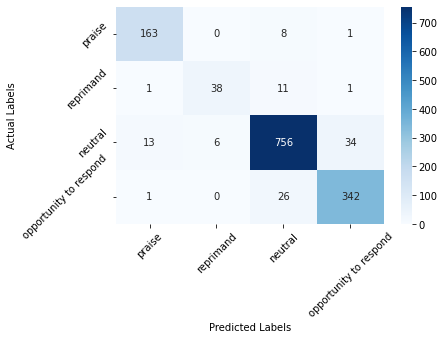

In [30]:
#use seaborne to display as heatmap
ax = sns.heatmap(c_df, cmap='Blues', annot=True, fmt='d');
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45);
ax.set_yticklabels(ax.get_yticklabels(),rotation = 45);

The x-axis shows the predicted labels and the y-axis shows the actual labels. 

Let's inspect this confusion matrix:
- This fine-tuned model did a quite good job to classify labels. Diagonal line from the right bottom to left top is the number of speech classfied correctly. We can see that most of speech belongs to this area.
- Among the misclassified area, the highest number is 34. This is when "neutral" speech is classified as "opportunity to respond". The second highest number is 26 and this is when "opportunity to respond" speech is classified as "neutral". These two situations show that our model is confused with "neutral" and "opportunity to respond" the most.

Great steps to improve from here include:
- In the dataset, the number of "neutral" speech outweigh that of other speechs. It would be better to train a model to discern between neutral and other classes first and then classify other labels.
- We can consider setting a specific cutoff number to decide if it is either "OTR" or "NEU". For example, if the probability is more than the cutoff number, then the prediction will be "OTR". Even if our model predicts a speech as "OTR", but the probability is lower than the cutoff number, the model should predict it as "NEU".

# Evaluate Performance Using Classification Report

Here, we'll just use the classification report function from sklearn. This will return the precision (positive predictive value), recall (sensitivity), and f1 score (harmonic mean of precision and recall) and accuracy.

In [36]:
perf_metrics = classification_report(val_final_df.dropna()['label'], val_final_df.dropna()['predict'], labels=train_classes, target_names = formal_labels)
print(perf_metrics)

                        precision    recall  f1-score   support

                praise       0.92      0.95      0.93       172
             reprimand       0.86      0.75      0.80        51
               neutral       0.94      0.93      0.94       809
opportunity to respond       0.90      0.93      0.92       369

              accuracy                           0.93      1401
             macro avg       0.91      0.89      0.90      1401
          weighted avg       0.93      0.93      0.93      1401



- Compared to other labels, 'reprimand' shows a low sensitivity. While other label's sensitivity is more than 0.9, that of 'reprimand' is 0.75. When we go back to the confusion matrix, there are 51 reprimand speech in the validation dataset. Among them, only 38 is correctly discerned, while 11s are misclassified as "NEU".
- This model's accuracy is 93%. In the 90 notebook, when we used "facebook/bart-large-mnli" model, the accuracy was 47%. When we used "typeform/distilbert-base-uncased-mnli" model in 93 notebook, the accuracy was 32%. Compared to these results from other models, this fine-tuned shows a really high accuracy. We can say that the process of fine-tuning improved the performance of a model.

# Examine validation dataset's misclassification

Now let's focus on misclassified speech. The outcome below shows the misclassified dataset.

In [32]:
# misclassfication
val_error = val_final_df[val_final_df.label != val_final_df.predict]
val_error = val_error.sort_values(by = 'score', ascending = False)
#val_error.to_csv("val_error.csv", index = False)

In [41]:
val_error.head(10)

,id,start_timestamp,end_timestamp,speech,label,predict,score
685,108-2,00:07:39.24,00:10:01.08,they're ready for the day (th*) to continue.,PRS,NEU,0.998124
869,123-2,00:04:09.21,00:05:42.00,so (everybody sai*) everybody agreed that it w...,OTR,NEU,0.997607
237,088-1,00:02:51.00,00:04:09.17,now let's think about where this story took pl...,OTR,NEU,0.997555
1253,254-1,00:01:21.04,00:02:00.10,excellent thoughts from all three of you guys.,OTR,PRS,0.996845
807,083-1,00:03:23.24,00:05:58.22,(now) see you can do it faster.,PRS,NEU,0.995130
225,273-2,00:08:23.00,00:09:09.08,person place.,OTR,NEU,0.994964
1023,254-1,00:05:18.21,00:06:34.00,(what else) what else can we guess.,PRS,OTR,0.992825
694,116-1,00:02:26.25,00:03:20.08,let's do our character.,OTR,NEU,0.991830
771,123-1,00:00:00.00,00:02:10.25,what?,NEU,OTR,0.991740
1335,107-3,00:00:00.00,00:02:12.05,oh yeah?,OTR,NEU,0.991722


After examinig the misclassified dataset, I realized that there are some speech of which actual "label" is wrong. This means when people manually gave groundtruth label to speech lines, they made a mistake to some speech lines. 

When you look at a speech with index 1253 in the dataset above, the label is "OTR", even though the speech "excellent thoughts from all three of you guys." is absolutely "PRS", which is "praise". Our model predicted this speech as "PRS", which I think it is correct. There are more examples of these "wrong" labels, which our model predicts, I think, correctly. For this reason, we should look at our misclassified data and increase the quality of the raw data, by correcting some labels while listening the audio files.